In [1]:
import torch
import glob
import re
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pyerrors as pe
from collections import defaultdict

In [3]:
def grab(var):
    if torch.is_tensor(var):
        return var.detach().cpu().numpy()
    else:
        return var

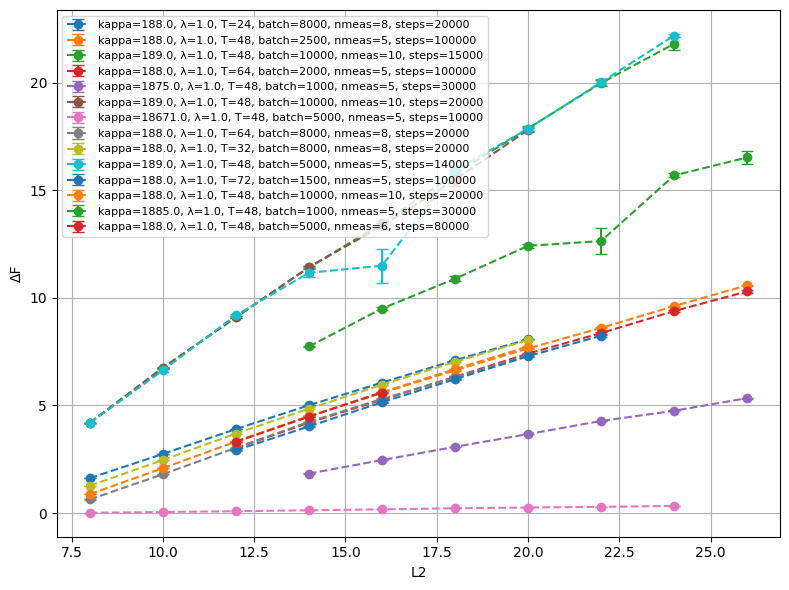

In [4]:
# pattern aggiornato: scalingData_L1-L2-T_kappa_lambda_batchsize_nmeas_steps.txt
pattern_new = re.compile(r"scalingData_(\d+)-(\d+)-(\d+)_(\d+)_(\d+)_(\d+)_(\d+)_(\d+)\.txt")

curve_data_new = []

for filename in glob.glob("scalingData_*.txt"):
    m = pattern_new.search(filename)
    if not m:
        continue
    L1, L2, T, kappa, lam, batchsize, nmeas, steps = m.groups()
    L1, L2, T = int(L1), int(L2), int(T)
    kappa, lam = float(kappa), float(lam)
    batchsize, nmeas, steps = int(batchsize), int(nmeas), int(steps)
    
    with open(filename, "r") as f:
        line = f.readline().strip()
    
    try:
        work_part, final_part = line.split(" || ", 1)
        final_vals = list(map(float, final_part.strip().split()))
        if len(final_vals) != 6:
            continue
        loss, loss_err, DF, DF_err, ESS, ESS_err = final_vals
    except Exception as e:
        print(f"Errore parsing {filename}: {e}")
        continue
    
    curve_data_new.append({
        "L1": L1, "L2": L2, "T": T,
        "kappa": kappa, "lambda": lam,
        "batchsize": batchsize, "nmeas": nmeas, "steps": steps,
        "loss": loss, "loss_err": loss_err,
        "DF": DF, "DF_err": DF_err,
        "ESS": ESS, "ESS_err": ESS_err
    })

# --- Raggruppamento per campioni ---
if curve_data_new:
    grouped = defaultdict(list)
    for e in curve_data_new:
        key = (e["kappa"], e["lambda"], e["T"], e["batchsize"], e["nmeas"], e["steps"])
        grouped[key].append(e)

    plt.figure(figsize=(8,6))
    for key, entries in grouped.items():
        entries = sorted(entries, key=lambda e: e["L2"])
        L2_vals = [e["L2"] for e in entries]
        DF_vals = [e["DF"] for e in entries]
        DF_errs = [e["DF_err"] for e in entries]
        
        label = f"kappa={key[0]}, λ={key[1]}, T={key[2]}, batch={key[3]}, nmeas={key[4]}, steps={key[5]}"
        plt.errorbar(L2_vals, DF_vals, yerr=DF_errs,
                     marker="o", linestyle="--", capsize=4, label=label)

    plt.xlabel("L2")
    plt.ylabel("ΔF")
    #plt.title("ΔF vs L2 per diversi campioni")
    plt.legend(fontsize=8)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("Nessun file riconosciuto.")


All the simulations performed during my thesis are represented here. The simulations are obtained by varying the parameters: kappa, lambda, lattice sides, batch size, number of measurements and number of steps.

Each colored line represents values of the interface free energy $\Delta F$ for different values of the lattice side $L_2$.

In [5]:
def fit_and_plot(model_func, key, param_names=None, title=None):
    """
    Esegue fit e plot dei dati di un campione selezionato con la funzione modello data.

    Args:
        model_func  : funzione Python f(L2, *params)
        key         : tupla (kappa, lambda, batchsize, nmeas, steps)
        param_names : lista di nomi parametri (opzionale)
        title       : titolo del grafico (opzionale)
    """
    # recupero il subset dal gruppo
    if key not in grouped:
        raise ValueError(f"Chiave {key} non trovata. Campioni disponibili: {list(grouped.keys())}")
    
    subset = sorted(grouped[key], key=lambda e: e["L2"])
    
    # estraggo i dati
    L1 = float(subset[0]["L1"])
    L2_vals = np.array([e["L2"] for e in subset], dtype=float)
    DF_vals = np.array([e["DF"] for e in subset], dtype=float)
    DF_errs = np.array([e["DF_err"] for e in subset], dtype=float)
    DKL_vals = np.array([e["loss"] - e["DF"] for e in subset], dtype=float)
    DKL_errs = np.array([e["loss_err"] + e["DF_err"] for e in subset], dtype=float)
    ESS_vals = np.array([e["ESS"] for e in subset], dtype=float)
    ESS_errs = np.array([e["ESS_err"] for e in subset], dtype=float)


    # fit
    popt, pcov = curve_fit(model_func, L2_vals, DF_vals, sigma=DF_errs, absolute_sigma=True)
    perr = np.sqrt(np.diag(pcov))

    # chi²
    residuals = DF_vals - model_func(L2_vals, *popt)
    chi2 = np.sum((residuals / DF_errs) ** 2)
    dof = len(L2_vals) - len(popt)
    chi2_red = chi2 / dof if dof > 0 else np.nan

    # stampa parametri
    if param_names is None:
        param_names = [f"p{i}" for i in range(len(popt))]
    print("Risultati fit per chiave", key)
    for name, val, err in zip(param_names, popt, perr):
        print(f"  {name} = {val:.6f} ± {err:.6f}")
    print(f"Chi^2 = {chi2:.2f}, ridotto = {chi2_red:.2f} (dof={dof})")

    # plot
    plt.figure(figsize=(7,5))
    (plotline, _, _) =plt.errorbar(L2_vals, DF_vals, yerr=DF_errs, marker="v", linestyle="none", capsize=4, label="Dati", color="green")
    plotline.set_markerfacecolor('none')
    plotline.set_markeredgewidth(0.8)

    xfit = np.linspace(min(L2_vals), max(L2_vals), 300)
    plt.plot(xfit, model_func(xfit, *popt), "g-", label="Fit", linewidth=0.5)
    plt.xlabel("$L_2$")
    plt.ylabel("$\Delta F$")
    if title:
        plt.title(title)
    #plt.legend()
    #plt.grid(True)
    plt.tight_layout()
    plt.show()

    #residuals_plot
    plt.figure(figsize=(8,3))
    (plotline, _, _) = plt.errorbar(L2_vals, residuals, yerr=DF_errs, marker="v", linestyle="none", capsize=4)
    plotline.set_markerfacecolor('none')
    plotline.set_markeredgewidth(0.8)

    plt.plot(L2_vals, np.zeros(len(L2_vals)), "-", linewidth=0.5, color="green")
    #plt.title("Residuals plot")
    plt.show()

    #ESS plot
    plt.errorbar(L2_vals, ESS_vals, yerr=ESS_errs, marker="p")
    plt.plot(L2_vals, np.array([0.1 for _ in range(len(L2_vals))]), "--", color="red")
    plt.title("ESS plot")
    plt.show()

    #DKL plot
    plt.errorbar(L2_vals, DKL_vals, yerr=DKL_errs, marker="*" )
    plt.plot(L2_vals, np.array([1 for _ in range(len(L2_vals))]), "--", color="red")
    plt.title("$D_{KL}$ plot")

    plt.show()


In [6]:
# Modelli per il fit

def luscher_term(x, sigma, k):
    L1 = 48
    return L1 * x * sigma - k * L1 / x

def luscher_term_get_sigma_c(x, sigma, c):
    L1 = 48
    return L1 * x * sigma - np.pi/6 * L1 / x + c

def luscher_term_get_sigma(x, sigma):
    L1 = 48
    return L1 * x * sigma - np.pi/6 * L1 / x 

def luscher_term_const(x, sigma, k, c):
    L1 = 48
    return L1 * x * sigma - k * L1 / x + c

def linear_model(x, a, b):
    return a*x + b

def third_order(x, sigma, k, e, c):
    L_1 = 48
    L_2 = x
    return L_1 * L_2 * sigma - k * L_1 / L_2 + e/sigma * L_1 / (L_2**3) +c

Now focusing on a single set of parameters, we can fit the resulting $\Delta F$s to get an estimate of the Luscher parameter k

Risultati fit per chiave (188.0, 1.0, 64, 2000, 5, 100000)
  sigma = 0.009380 ± 0.000175
  k = 0.473795 ± 0.042718
  c = -0.492991 ± 0.267389
Chi^2 = 7.36, ridotto = 1.47 (dof=5)


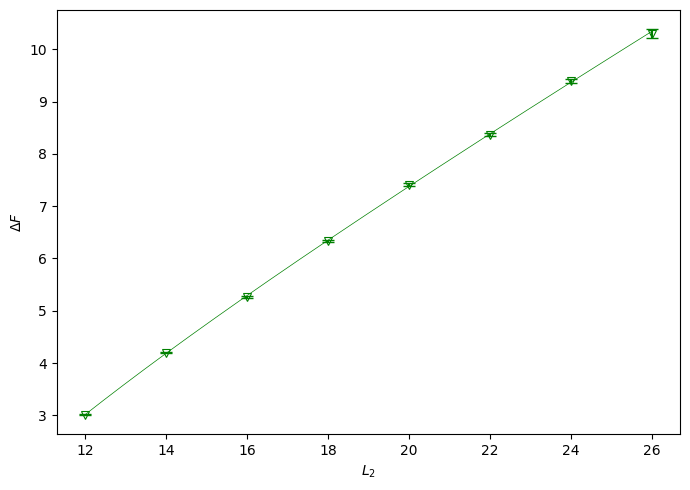

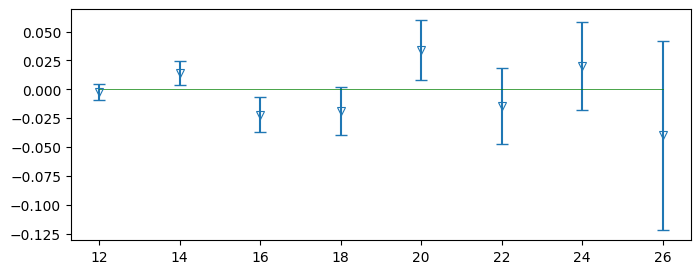

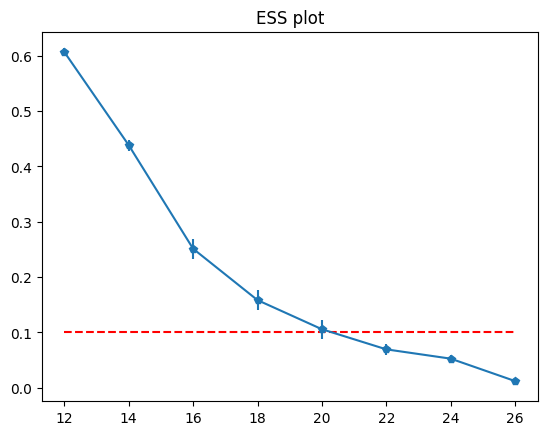

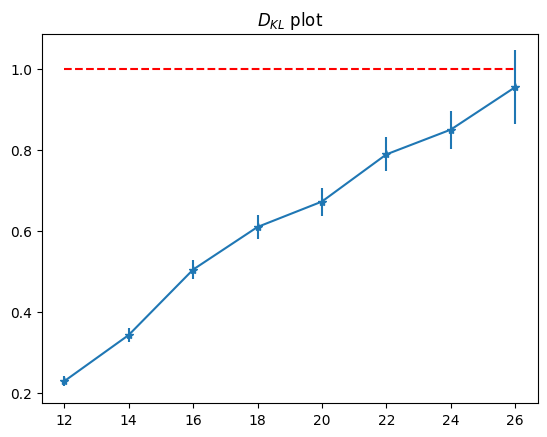

In [141]:
# ---------------------------------------------------------
# Uso del fit sui campioni con le funzioni modello
# ---------------------------------------------------------

# la chiave che vuoi analizzare (kappa, lambda, batch, nmeas, steps)
key = (188.0, 1.0, 64, 2000, 5, 100000)
#188.0, 1.0, 2000, 5, 100000

# recupero il subset corrispondente
if key not in grouped:
    raise ValueError(f"Chiave {key} non trovata. Campioni disponibili: {list(grouped.keys())}")
subset = sorted(grouped[key], key=lambda e: e["L2"])
L1_val = float(subset[0]["L1"])  # serve per i modelli che dipendono da L1

fit_and_plot(luscher_term_const, key, param_names=["sigma", "k", "c"])

In [156]:
def fit_and_plotV2(model_func, key, param_names=None, title=None):
    """
    Esegue fit e plot dei dati di un campione selezionato con la funzione modello data.
    Mostra in un'unica figura:
        - ΔF vs L2 con fit
        - Residui sotto, più basso e largo uguale
    Segue con due plot separati per ESS e DKL.
    """
    if key not in grouped:
        raise ValueError(f"Chiave {key} non trovata. Campioni disponibili: {list(grouped.keys())}")
    
    subset = sorted(grouped[key], key=lambda e: e["L2"])
    
    # estraggo i dati
    L1 = float(subset[0]["L1"])
    L2_vals = np.array([e["L2"] for e in subset], dtype=float)
    DF_vals = np.array([e["DF"] for e in subset], dtype=float)
    DF_errs = np.array([e["DF_err"] for e in subset], dtype=float)
    DKL_vals = np.array([e["loss"] - e["DF"] for e in subset], dtype=float)
    DKL_errs = np.array([e["loss_err"] + e["DF_err"] for e in subset], dtype=float)
    ESS_vals = np.array([e["ESS"] for e in subset], dtype=float)
    ESS_errs = np.array([e["ESS_err"] for e in subset], dtype=float)

    # --- Fit ---
    popt, pcov = curve_fit(model_func, L2_vals, DF_vals, sigma=DF_errs, absolute_sigma=True)
    perr = np.sqrt(np.diag(pcov))

    residuals = DF_vals - model_func(L2_vals, *popt)
    chi2 = np.sum((residuals / DF_errs) ** 2)
    dof = len(L2_vals) - len(popt)
    chi2_red = chi2 / dof if dof > 0 else np.nan

    # Stampa risultati
    if param_names is None:
        param_names = [f"p{i}" for i in range(len(popt))]
    print(f"Risultati fit per chiave {key}")
    for name, val, err in zip(param_names, popt, perr):
        print(f"  {name} = {val:.6f} ± {err:.6f}")
    print(f"Chi^2 = {chi2:.2f}, ridotto = {chi2_red:.2f} (dof={dof})")

    # --- Figura combinata: ΔF + residui ---
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7,6), 
                                   gridspec_kw={'height_ratios':[3,1], 'hspace':0.05}, 
                                   sharex=True)

    # Plot principale: ΔF vs L2
    ax1.errorbar(L2_vals, DF_vals, yerr=DF_errs, marker="v", linestyle="none", capsize=4, label="Dati",
                 mfc='none', mec='steelblue', mew=0.8)
    xfit = np.linspace(min(L2_vals), max(L2_vals), 300)
    ax1.plot(xfit, model_func(xfit, *popt), "r-", color="green", linewidth=0.8, label="Fit")

    ax1.set_ylabel(r"$\Delta F$")
    if title:
        ax1.set_title(title)
    ax1.grid(True)
    ax1.legend()

    # Plot residui sotto
    ax2.errorbar(L2_vals, residuals, yerr=DF_errs, marker="v", linestyle="none", capsize=4,
                 mfc='none', mec='steelblue', mew=0.8)
    ax2.axhline(0, color="green", linestyle="-", linewidth=0.8)
    ax2.set_xlabel(r"$L_2$")
    ax2.set_ylabel("Residuals")
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

    # --- Plot ESS ---
    plt.figure(figsize=(6,4))
    plt.errorbar(L2_vals, ESS_vals, yerr=ESS_errs, marker="p", capsize=4)
    plt.axhline(0.1, linestyle="--", color="red", linewidth=0.8)
    plt.title("ESS plot")
    plt.xlabel(r"$L_2$")
    plt.ylabel("ESS")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- Plot DKL ---
    plt.figure(figsize=(6,4))
    plt.errorbar(L2_vals, DKL_vals, yerr=DKL_errs, marker="*", capsize=4)
    plt.axhline(1.0, linestyle="--", color="red", linewidth=0.8)
    plt.title(r"$D_{KL}$ plot")
    plt.xlabel(r"$L_2$")
    plt.ylabel(r"$D_{KL}$")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Risultati fit per chiave (188.0, 1.0, 64, 2000, 5, 100000)
  sigma = 0.009380 ± 0.000175
  k = 0.473795 ± 0.042718
  c = -0.492991 ± 0.267389
Chi^2 = 7.36, ridotto = 1.47 (dof=5)


/var/folders/j5/h2949_ys0s1blqt032r700th0000gn/T/ipykernel_3074/3129221366.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  ax1.plot(xfit, model_func(xfit, *popt), "r-", color="green", linewidth=0.8, label="Fit")
/var/folders/j5/h2949_ys0s1blqt032r700th0000gn/T/ipykernel_3074/3129221366.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


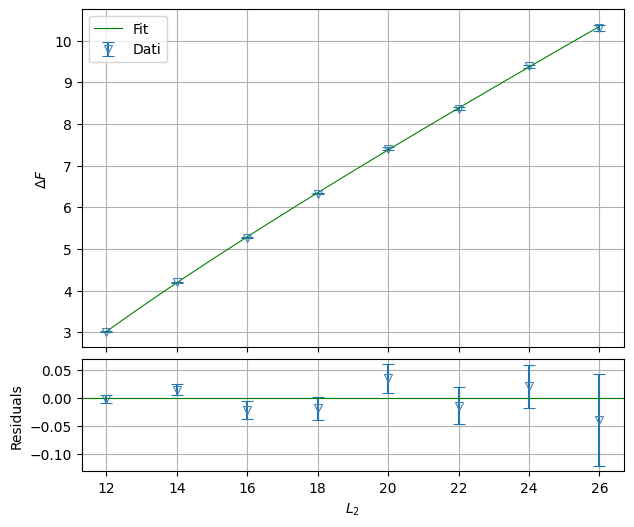

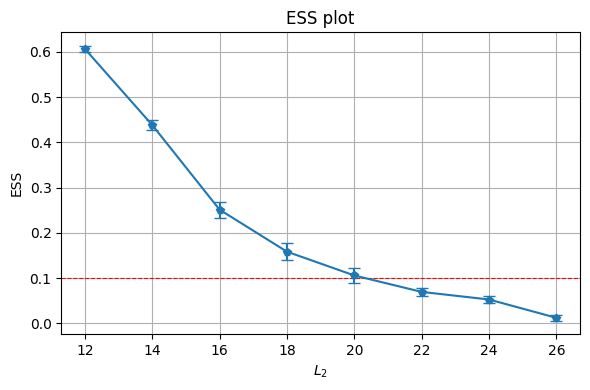

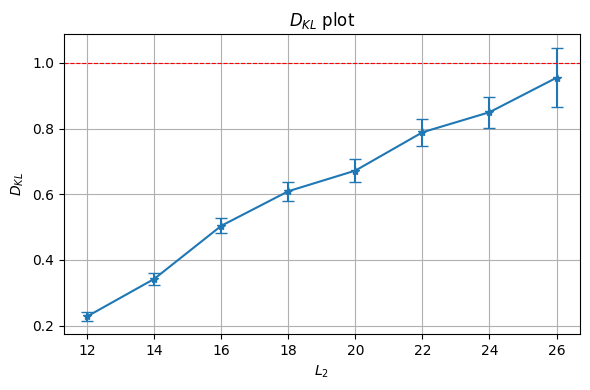

In [157]:
key = (188.0, 1.0, 64, 2000, 5, 100000)
#188.0, 1.0, 2000, 5, 100000

# recupero il subset corrispondente
if key not in grouped:
    raise ValueError(f"Chiave {key} non trovata. Campioni disponibili: {list(grouped.keys())}")
subset = sorted(grouped[key], key=lambda e: e["L2"])
L1_val = float(subset[0]["L1"])  # serve per i modelli che dipendono da L1

fit_and_plotV2(luscher_term_const, key, param_names=["sigma", "k", "c"])

Fit con modello di tipo Lüscher:
sigma = 0.009380 ± 0.000175
k      = 0.473795 ± 0.042718
c      = -0.492991 ± 0.267389
χ² = 7.36, χ²_rid = 1.47 (dof=5)

Fit lineare:
a = 0.010184 ± 0.000200
b = -2.371090 ± 0.209451
χ² = 5399.28, χ²_rid = 899.88 (dof=6)


/var/folders/j5/h2949_ys0s1blqt032r700th0000gn/T/ipykernel_64608/3258051311.py:108: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


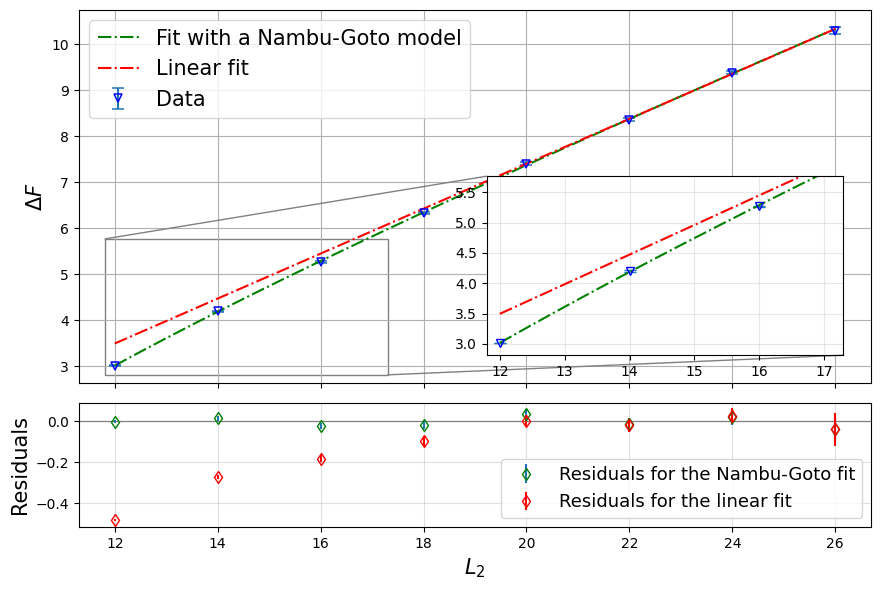

In [9]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

# --- Modelli ---
def luscher_term_const(x, sigma, k, c):
    L1 = 48
    return L1 * x * sigma - k * L1 / x + c

def linear_model(x, a, b):
    L1 = 48
    return L1 * a * x + b

# --- Dati ---
L2 = np.array([12, 14, 16, 18, 20, 22, 24, 26], dtype=float)
DeltaF = np.array([3.0125262462396907, 4.200374644922847, 5.267965845814388, 6.329403102982862,
                   7.409318303444064, 8.364786711991634, 9.385917267126004, 10.299237865755703], dtype=float)
DeltaF_err = np.array([0.0071824378217583565, 0.010111266105466548, 0.015369757931564393, 0.0206825745986653,
                       0.025992882491857546, 0.03286416139856933, 0.03795111504816635, 0.0815942999441767], dtype=float)

# --- Fit Lüscher ---
popt_l, pcov_l = curve_fit(luscher_term_const, L2, DeltaF, sigma=DeltaF_err, absolute_sigma=True)
perr_l = np.sqrt(np.diag(pcov_l))

# --- Fit lineare ---
popt_lin, pcov_lin = curve_fit(linear_model, L2[4:], DeltaF[4:], sigma=DeltaF_err[4:], absolute_sigma=True)
#popt_lin = [popt_l[0], popt_l[2]]
#pcov_lin = [pcov_l[0], pcov_l[2]]
#popt_lin[1] -= 0.95

perr_lin = np.sqrt(np.diag(pcov_lin))

# --- Residui e chi² ---
res_l = (DeltaF - luscher_term_const(L2, *popt_l))
res_lin = (DeltaF - linear_model(L2, *popt_lin))

chi2_l = np.sum((res_l / DeltaF_err) ** 2)
chi2_lin = np.sum((res_lin / DeltaF_err) ** 2)
dof_l = len(L2) - len(popt_l)
dof_lin = len(L2) - len(popt_lin)
chi2red_l = chi2_l / dof_l
chi2red_lin = chi2_lin / dof_lin

# --- Stampa risultati ---
print("Fit con modello di tipo Lüscher:")
print(f"sigma = {popt_l[0]:.6f} ± {perr_l[0]:.6f}")
print(f"k      = {popt_l[1]:.6f} ± {perr_l[1]:.6f}")
print(f"c      = {popt_l[2]:.6f} ± {perr_l[2]:.6f}")
print(f"χ² = {chi2_l:.2f}, χ²_rid = {chi2red_l:.2f} (dof={dof_l})")
print()
print("Fit lineare:")
print(f"a = {popt_lin[0]:.6f} ± {perr_lin[0]:.6f}")
print(f"b = {popt_lin[1]:.6f} ± {perr_lin[1]:.6f}")
print(f"χ² = {chi2_lin:.2f}, χ²_rid = {chi2red_lin:.2f} (dof={dof_lin})")

# --- Range zoom regolabile ---
zoom_min, zoom_max = 11.8, 17.3

# --- Plot principale + residui ---
xfit = np.linspace(min(L2), max(L2), 300)

fig, (ax, ax_res) = plt.subplots(
    2, 1,
    figsize=(9, 6),
    gridspec_kw={'height_ratios': [3, 1]},
    sharex=True
)

# --- Plot principale ---
ax.errorbar(L2, DeltaF, yerr=DeltaF_err, marker="v", linestyle="none", capsize=4, label="Data",
                mfc='none', mec='blue', mew=1.1)
ax.plot(xfit, luscher_term_const(xfit, *popt_l), 'g-.', label="Fit with a Nambu-Goto model")
ax.plot(xfit, linear_model(xfit, *popt_lin), 'r-.', label="Linear fit")

ax.set_ylabel("$\\Delta F$", fontsize = 15)
#ax.set_title("$\\Delta F$ vs $L_2$: confronto tra fit Lüscher e lineare")
ax.legend(fontsize = 15)
ax.grid(True)
#ax.grid(False)

# --- Inset zoom ---
axins = inset_axes(ax, width="45%", height="48%", loc='lower right', borderpad=2)
axins.errorbar(L2, DeltaF, yerr=DeltaF_err, fmt='v', mec='blue', capsize=4, mfc='none')
axins.plot(xfit, luscher_term_const(xfit, *popt_l), 'g-.')
axins.plot(xfit, linear_model(xfit, *popt_lin), 'r-.')

axins.set_xlim(zoom_min, zoom_max)
axins.set_ylim(
    min(DeltaF[L2 >= zoom_min]) - 0.2,
    max(DeltaF[L2 <= zoom_max]) + 0.5
)
axins.grid(True, alpha=0.3)
#axins.grid(False)
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

# --- Plot residui ---
ax_res.axhline(0, color='grey', linestyle='-', linewidth=0.9)
ax_res.errorbar(L2, res_l, yerr=DeltaF_err, fmt='d', label='Residuals for the Nambu-Goto fit', mfc='none', mec='green')
ax_res.errorbar(L2, res_lin, yerr=DeltaF_err, fmt='d', color='red', label='Residuals for the linear fit', mfc='none', mec='red')

ax_res.set_xlabel("$L_2$", fontsize = 15)
ax_res.set_ylabel("Residuals", fontsize = 15)
ax_res.grid(True, alpha=0.4)
#ax_res.grid(False)
ax_res.legend(fontsize=13)

plt.tight_layout()
plt.show()


As can be seen, the data differs from the linear approximation (which is acceptable only at large values of $L_2$) in red. 

## Sigma vs Hopping

A brief study of the string tension $\sigma$ as a function of the Hopping parameter k. The string tension is expected to vanish at the critical point, with a universal critical index $\nu$

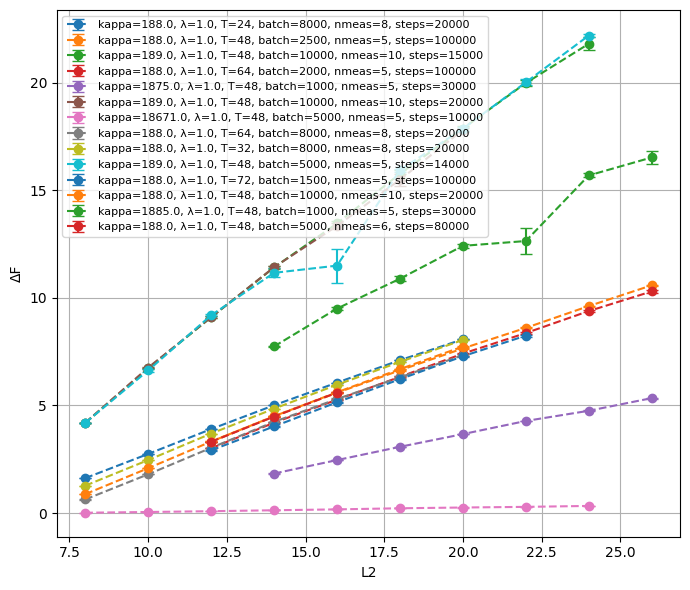

In [209]:
# pattern aggiornato: scalingData_L1-L2-T_kappa_lambda_batchsize_nmeas_steps.txt
pattern_new = re.compile(r"scalingData_(\d+)-(\d+)-(\d+)_(\d+)_(\d+)_(\d+)_(\d+)_(\d+)\.txt")

curve_data_new = []

for filename in glob.glob("scalingData_*.txt"):
    m = pattern_new.search(filename)
    if not m:
        continue
    L1, L2, T, kappa, lam, batchsize, nmeas, steps = m.groups()
    L1, L2, T = int(L1), int(L2), int(T)
    kappa, lam = float(kappa), float(lam)
    batchsize, nmeas, steps = int(batchsize), int(nmeas), int(steps)
    
    with open(filename, "r") as f:
        line = f.readline().strip()
    
    try:
        work_part, final_part = line.split(" || ", 1)
        final_vals = list(map(float, final_part.strip().split()))
        if len(final_vals) != 6:
            continue
        loss, loss_err, DF, DF_err, ESS, ESS_err = final_vals
    except Exception as e:
        print(f"Errore parsing {filename}: {e}")
        continue
    
    curve_data_new.append({
        "L1": L1, "L2": L2, "T": T,
        "kappa": kappa, "lambda": lam,
        "batchsize": batchsize, "nmeas": nmeas, "steps": steps,
        "loss": loss, "loss_err": loss_err,
        "DF": DF, "DF_err": DF_err,
        "ESS": ESS, "ESS_err": ESS_err
    })

# --- Raggruppamento per campioni ---
if curve_data_new:
    grouped = defaultdict(list)
    for e in curve_data_new:
        key = (e["kappa"], e["lambda"], e["T"], e["batchsize"], e["nmeas"], e["steps"])
        grouped[key].append(e)

    plt.figure(figsize=(7,6))
    for key, entries in grouped.items():
        entries = sorted(entries, key=lambda e: e["L2"])
        L2_vals = [e["L2"] for e in entries]
        DF_vals = [e["DF"] for e in entries]
        DF_errs = [e["DF_err"] for e in entries]
        
        label = f"kappa={key[0]}, λ={key[1]}, T={key[2]}, batch={key[3]}, nmeas={key[4]}, steps={key[5]}"
        plt.errorbar(L2_vals, DF_vals, yerr=DF_errs,
                     marker="o", linestyle="--", capsize=4, label=label)

    plt.xlabel("L2")
    plt.ylabel("ΔF")
    #plt.title("ΔF vs L2 per diversi campioni")
    plt.legend(fontsize=8)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("Nessun file riconosciuto.")


In [ ]:
189, 1, 48, 5000, 5, 14000
1885, 1, 48, 1000, 5, 30000
188, 1, 48, 2500, 5, 100000
1875, 1, 48, 1000, 5, 30000
18671, 1, 48, 5000, 5, 10000

kappa sigma sigma.err
0.189 0.020659 0.000072
0.1885 0.014683 0.000187
0.188 0.009086 0.000019
0.1875 0.004624 0.000034
0.18671 0.000444 0.000056

Risultati fit per chiave (18671, 1, 48, 5000, 5, 10000)
  sigma = 0.000444 ± 0.000016
  k = -0.004641 ± 0.002635
  c = -0.182479 ± 0.020565
Chi^2 = 13.13, ridotto = 2.19 (dof=6)


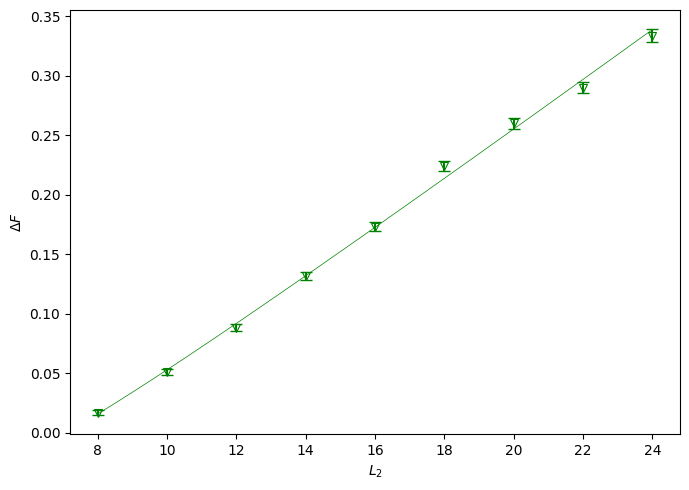

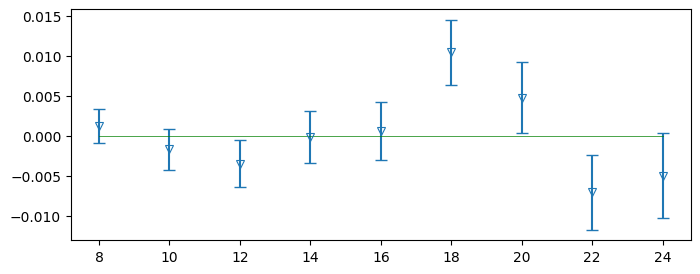

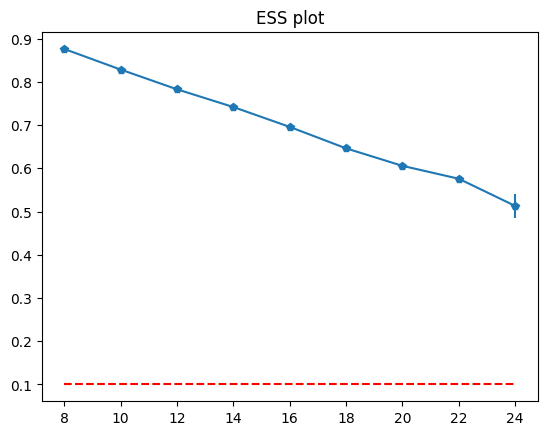

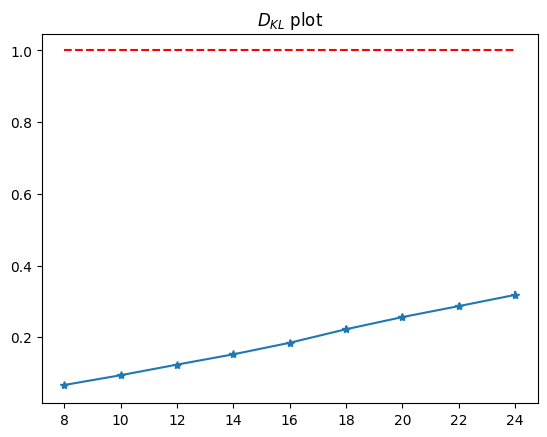

In [216]:
# ---------------------------------------------------------
# Uso del fit sui campioni con le funzioni modello
# ---------------------------------------------------------

# la chiave che vuoi analizzare (kappa, lambda, batch, nmeas, steps)
key = (18671, 1, 48, 5000, 5, 10000)
#188.0, 1.0, 2000, 5, 100000

# recupero il subset corrispondente
if key not in grouped:
    raise ValueError(f"Chiave {key} non trovata. Campioni disponibili: {list(grouped.keys())}")
subset = sorted(grouped[key], key=lambda e: e["L2"])
L1_val = float(subset[0]["L1"])  # serve per i modelli che dipendono da L1

fit_and_plot(luscher_term_const, key, param_names=["sigma", "k", "c"])

In [224]:
#data:
A = np.array([[0.189, 0.020659, 0.000072],
[0.1885, 0.014683, 0.000187],
[0.188, 0.009086, 0.000019],
[0.1875, 0.004624, 0.000034],
[0.18671, 0.000444, 0.000056]])
A[:,0]

array([0.189  , 0.1885 , 0.188  , 0.1875 , 0.18671])

Fit con nu fissato a 0.6301
  sigma0 = 1.195975e+02 ± 4.765693e+00
  nu = 7.011939e-01 ± 2.997683e-03
  chi² = 8.70, chi²/dof = 2.90 (dof=3)


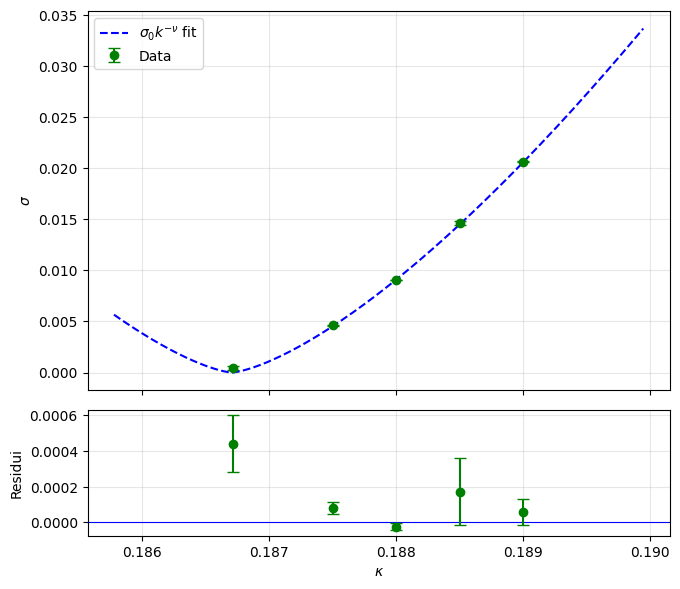

In [14]:
# cell: fit sigma(k) = sigma0 * k^{-nu} with nu fixed
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Dati: (k, sigma, sigma_err)
A = np.array([
    [0.189,   0.020659, 0.000072],
    [0.1885,  0.014683, 0.000187],
    [0.188,    0.009086, 0.000019],
    [0.1875,  0.004624, 0.000034],
    [0.18671, 0.000444, 0.00016]
])

k_vals = A[:,0]
sigma_vals = A[:,1]
sigma_errs = A[:,2]

# --- SCEGLI IL VALORE DI nu QUI ---
# Default: nu = 1.0 (Ising 2D, tipico valore per la divergenza della lunghezza di correlazione)
# Se vuoi usare il valore 3D, imposta nu = 0.6301
nu_fixed = 0.6301
# nu_fixed = 0.6301

# Modello con nu fissato: sigma = sigma0 * k^{-nu_fixed}
def sigma_model_fixed_nu(k, sigma0, nu):
    return sigma0 * np.abs(k - 0.18670475) **(1/nu)

# stima iniziale ragionevole per sigma0 (mediata sui dati trasformati)
# sigma0 ~ mean( sigma * k^{nu} )
sigma0_init = np.mean(sigma_vals * (k_vals**nu_fixed))
nu0 = nu_fixed

# Fit di un solo parametro sigma0 (usando i pesi dalle incertezze)
popt, pcov = curve_fit(
    sigma_model_fixed_nu,
    k_vals[:-1], sigma_vals[:-1],
    sigma=sigma_errs[:-1],
    absolute_sigma=True,
    p0=[sigma0_init, nu0],
    maxfev=10000
)
sigma0 = popt[0]
sigma0_err = np.sqrt(np.diag(pcov))[0]
nu0 = popt[1]

# Residui e chi^2
residuals = np.zeros(len(k_vals))
residuals[:-1] = sigma_vals[:-1] - sigma_model_fixed_nu(k_vals[:-1], sigma0, nu0)
chi2 = np.sum((residuals[:-1] / sigma_errs[:-1])**2)
dof = len(k_vals[:-1]) - 1  # uno solo parametro
chi2_red = chi2 / dof if dof>0 else np.nan
residuals[4] = sigma_vals[-1] - sigma_model_fixed_nu(k_vals[-1], sigma0, nu0)

# Stampa risultati
print(f"Fit con nu fissato a {nu_fixed}")
print(f"  sigma0 = {sigma0:.6e} ± {sigma0_err:.6e}")
print(f"  nu = {popt[1]:.6e} ± {np.sqrt(np.diag(pcov))[1]:.6e}")
print(f"  chi² = {chi2:.2f}, chi²/dof = {chi2_red:.2f} (dof={dof})")

# --- Plot: fit + residuals (layout compatto) ---
k_fit = np.linspace(k_vals.min()*0.995, k_vals.max()*1.005, 400)
sigma_fit = sigma_model_fixed_nu(k_fit, *popt)

fig, (ax_top, ax_bot) = plt.subplots(2,1, figsize=(7,6), gridspec_kw={'height_ratios':[3,1]}, sharex=True)

# top: data + fit
ax_top.errorbar(k_vals, sigma_vals, yerr=sigma_errs, fmt='o', capsize=4, label='Data', color = "green")
ax_top.plot(k_fit, sigma_fit, 'b--', label=rf'$\sigma_0 k^{{- \nu}}$ fit')
ax_top.set_ylabel(r'$\sigma$')
#ax_top.set_title(r'$\sigma (k)$')
ax_top.grid(True, alpha=0.3)
ax_top.legend()

# bottom: residuals
#print("len k: ", len(k_vals))
#print("residuals: ", len(residuals))
ax_bot.axhline(0, color='blue', linewidth=0.8)
ax_bot.errorbar(k_vals, residuals, yerr=sigma_errs, fmt='o', capsize=4, color = "green")
ax_bot.set_xlabel(r'$\kappa$')
ax_bot.set_ylabel('Residui')
ax_bot.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
